<a href="https://colab.research.google.com/github/Amir-D-Shadow/Google-Colab/blob/main/Fourier_Transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
import numpy as np
import os 
import cv2
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt

In [3]:
path = os.getcwd()

In [4]:
img = cv2.imread(f"{path}/gdrive/MyDrive/test01.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

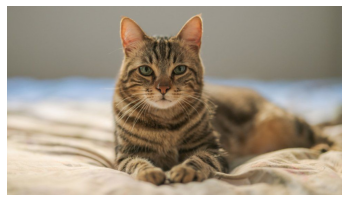

In [5]:
plt.axis("off")
plt.imshow(img)

In [6]:
img_FT = tf.signal

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


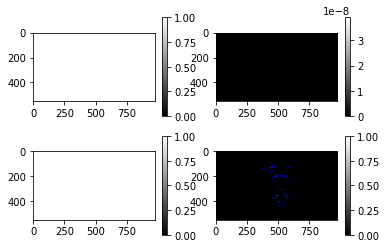

In [7]:
#img_FT = np.fft.fft2(img,axes=(-3,-2))
#img_FT = np.fft.fftn(img,axes=(-2,-3))
img_FT =  np.fft.fftn(np.fft.fftn(img,axes=(-2,-3)),axes=(0,1)) 

img_FT_shift = np.fft.fftshift(img_FT)


img_FT_scale_min = img_FT.real - img_FT.real * np.maximum(img_FT.real-5e7,0)/(img_FT.real - 5e7)
img_FT_scale_max = img_FT.real - img_FT.real * np.maximum(1e8-img_FT.real,1e7)/((1e7-img_FT.real))


#img_FT_scale = img_FT.real - img_FT_scale_max - img_FT_scale_min
img_FT_scale = img_FT  - img_FT_scale_max.astype(np.complex128) - img_FT_scale_min.astype(np.complex128)

plt.subplot(2,2,1)
plt.imshow(img_FT.real,cmap="gray")
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(img_FT.imag,cmap="gray")
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(img_FT_shift.real,cmap="gray")
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(img_FT_scale.real,cmap="gray")
plt.colorbar()

In [8]:
img_FT[img_FT<0].shape

(21,)

In [9]:
#img_new_FT = img_FT - img_FT.real + img_FT_scale
img_new_FT = img_FT - img_FT_scale_max.astype(np.complex128) - img_FT_scale_min.astype(np.complex128) 

In [10]:
#img_res = np.fft.ifft2(img_new_FT,axes=(-3,-2))
img_res = np.fft.ifftn(np.fft.ifftn(img_new_FT,axes=(-3,-2)),axes=(0,1)) 

In [11]:
print(type(np.uint64(img_res[0,0,0])))

<class 'numpy.uint64'>


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


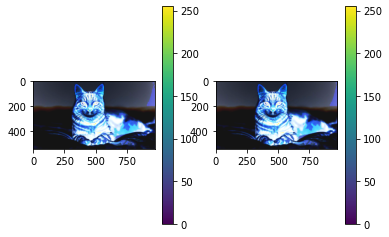

In [12]:
plt.subplot(1,2,1)
plt.imshow(np.uint64(np.abs(img_res)))
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.uint64(np.abs(img_res.real)))
plt.colorbar()

In [13]:
def experiment_FFT1D(arr):

    N = arr.shape[0]
    
    if N == 1:
        return arr
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j*np.pi*np.arange(N)/ N)
        
        X = np.concatenate([X_even+factor[:int(N/2)]*X_odd,X_even+factor[int(N/2):]*X_odd])
        
        return X

In [14]:
a = np.random.randn(1,9)

b = np.fft.fft(a.copy())
c = experiment_FFT1D(a.copy())
np.allclose(b,c)

False

In [15]:
def FFT_vectorized(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    N_min = min(N, 32)
    
    # Perform an O[N^2] DFT on all length-N_min sub-problems at once
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))

    # build-up each level of the recursive calculation all at once
    while X.shape[0] < N:
        X_even = X[:, : int(X.shape[1] / 2)]
        X_odd = X[:, int(X.shape[1] / 2):]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel()

In [16]:
x = np.random.random(1024 * 16)
%timeit a = FFT_vectorized(x)
%timeit b = np.fft.fft(x)
np.allclose(a,b)

100 loops, best of 5: 4.6 ms per loop
1000 loops, best of 5: 286 µs per loop


False

In [17]:
def experiment_dft_one_step(img,a,b,c):

    H,W,_ = img.shape

    val = 0

    for h in range(H):

        for w in range(W):

            exponent = complex(0,-2*np.pi*(a*h/H+b*w/W))

            val = val + img[h,w,c] * np.exp(exponent)

    return val



def experiment_dft(img):

    H,W,C = img.shape

    img_FT = np.zeros_like(img).astype(np.complex128)

    for c in range(C):

        for h in range(H):

            for w in range(W):
                
                img_FT[h,w,c] = experiment_dft_one_step(img,h,w,c)


    return img_FT

In [18]:
a = np.random.randn(4,4,3)
b = np.fft.fft2(a,axes=(0,1))
d = np.fft.fftn(a,axes=(-2,-3))
c = experiment_dft(a)
f = tf.signal.fft2d(a)

In [19]:
a = np.random.randn(32,32,3)
b = np.fft.fftn(np.fft.fft2(a,axes=(0,1)),axes=(0,1))
d = np.fft.fftn(np.fft.fftn(a,axes=(-2,-3)),axes=(0,1))
c = experiment_dft(experiment_dft(a))
f = tf.signal.fft2d(a)

In [20]:
np.allclose(b,c),np.allclose(b,d)

(True, True)

In [21]:
print(np.allclose(f.numpy(),c),np.allclose(f.numpy(),d),np.allclose(f.numpy(),b))

False False False


In [22]:
a = np.arange(12).reshape(2,2,3)
b = np.full(shape=(1,1,3),fill_value=5)

In [23]:
c  = np.maximum(a,b)

In [24]:
a

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])

In [25]:
a[:,:,0]

array([[0, 3],
       [6, 9]])

In [26]:
c

array([[[ 5,  5,  5],
        [ 5,  5,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])

In [27]:
d = np.full(shape=(1,),fill_value=9)
f = np.maximum(a,d)

In [28]:
f

array([[[ 9,  9,  9],
        [ 9,  9,  9]],

       [[ 9,  9,  9],
        [ 9, 10, 11]]])

In [29]:
def experiment_idft_one_step(img,a,b,c):

    H,W,_ = img.shape

    val = 0

    for h in range(H):

        for w in range(W):

            exponent = complex(0,2*np.pi*(a*h/H+b*w/W))

            val = val + img[h,w,c] * np.exp(exponent)

    val = val/(H*W)
 
    return val



def experiment_idft(img):

    H,W,C = img.shape

    img_iFT = np.zeros_like(img).astype(np.complex128)

    for c in range(C):

        for h in range(H):

            for w in range(W):
                
                img_iFT[h,w,c] = experiment_idft_one_step(img,h,w,c)

    #img_iFT = img_iFT/(H*W)
    return img_iFT

In [30]:
a = np.random.randn(2,2,3)
b = np.fft.ifft2(a,axes=(0,1))
d = np.fft.ifftn(a,axes=(-2,-3))

c = experiment_idft(a)


In [31]:
np.allclose(b,c),np.allclose(b,d)

(True, True)

In [32]:
#a = tf.constant(np.random.randn(6,3,3,5))
a = np.random.randn(6,3,3,5)
b = tf.keras.layers.Conv2D(2,2,1,padding="same")(a)
c = tf.keras.layers.LeakyReLU()(b)

In [33]:
type(b)

tensorflow.python.framework.ops.EagerTensor

In [34]:
type(c)

tensorflow.python.framework.ops.EagerTensor

In [35]:
c.shape

TensorShape([6, 3, 3, 2])

In [36]:
d = np.fft.fftn(c,axes=(-2,-3))

In [37]:
type(d)

numpy.ndarray

In [38]:
img = cv2.imread(f"{path}/gdrive/MyDrive/test01.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = img[np.newaxis,:,:,:]
print(img.shape)

(1, 549, 976, 3)


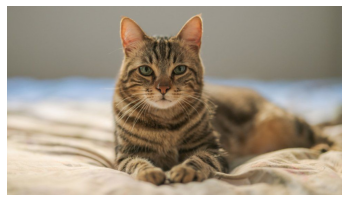

In [39]:
plt.axis("off")
plt.imshow(img[0,:,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


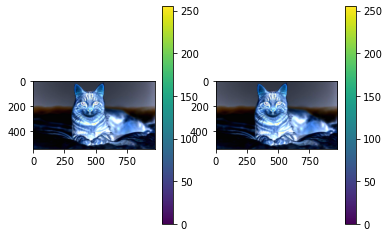

In [40]:
img_FT =  tf.signal.fft2d(tf.signal.fft2d(img)) 

img_FT_real = tf.math.real(img_FT)

img_FT_scale_min = img_FT_real - img_FT_real * K.maximum(img_FT_real-1e2,0)/(img_FT_real - 1e4)
img_FT_scale_max = img_FT_real - img_FT_real * K.maximum(6e5-img_FT_real,0)/((6e4-img_FT_real))

img_new_FT = img_FT - K.cast(img_FT_scale_max,K.dtype(img_FT)) - K.cast(img_FT_scale_min,K.dtype(img_FT))

img_res = tf.signal.ifft2d(tf.signal.ifft2d(img_new_FT)) 

img_res = img_res.numpy()[0,:,:,:]

plt.subplot(1,2,1)
plt.imshow(np.uint64(np.abs(img_res)))
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.uint64(np.abs(img_res.real)))
plt.colorbar()

(549, 976, 3)


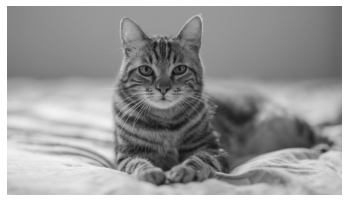

In [41]:
img = cv2.imread(f"{path}/gdrive/MyDrive/test01.jpg",0)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#img = img[np.newaxis,:,:,:]
print(img.shape)
plt.axis("off")
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


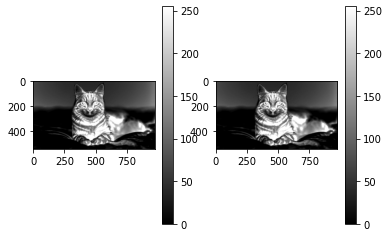

In [42]:
img_FT =  tf.signal.fft3d(tf.signal.fft3d(img)) 

img_FT_real = tf.math.real(img_FT)

img_FT_scale_min = img_FT_real - img_FT_real * K.maximum(img_FT_real-5e5,0)/(img_FT_real - 5e5)
img_FT_scale_max = img_FT_real - img_FT_real * K.maximum(3e8-img_FT_real,0)/((5e7-img_FT_real))

img_new_FT = img_FT - K.cast(img_FT_scale_max,K.dtype(img_FT)) - K.cast(img_FT_scale_min,K.dtype(img_FT))

img_res = tf.signal.ifft3d(tf.signal.ifft3d(img_new_FT)) 

img_res = img_res.numpy()

plt.subplot(1,2,1)
plt.imshow(np.uint64(np.abs(img_res)),cmap="gray")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.uint64(np.abs(img_res.real)),cmap="gray")
plt.colorbar()

In [43]:
a = K.sum(img_FT_real[tf.newaxis,:,:,:],axis=(1,2,3),keepdims=True)